# NER for Resumes Analysis and Matching Job System

## Abstract

It is becoming increasingly difficult for employers to identify suitable applicants quickly and effectively from the increasing numbers of people applying for jobs. The traditional manual resume screening methods are time-consuming and prone to human errors. This study examines the use of advanced Natural Language Processing (NLP) methods, particularly Named Entity Recognition (NER), in order to automatizate resume categorization as well as improve hiring processes. We use state-of-the-art deep learning models such as  RoBERTa (a robustly optimized BERT technique) to test various NER approaches.


Resume dataset: https://www.kaggle.com/datasets/dataturks/resume-entities-for-ner

JobPost dataset: https://www.kaggle.com/datasets/promptcloud/indeed-india-job-listing-data?resource=download

NER techniques Identifies and classifies text entities (e.g., names, dates, organizations).

In NER, a named entity(data mining) is a real-world object, such as a personal organization, location, product, etc. represented by a proper name.

NER Techniques:

Rule-Based: Utilizes predefined rules and dictionaries for specific entity patterns;

Machine Learning-Based:

*   Supervised: Relies on annotated data and models (ANN, SVM) for accuracy;

*   Unsupervised:Does not require annotated training data and attempts to create; potential annotations from the data but it doesn't yield good results.

Hybrid-Based: Leverages both Rule-Based and Ml-Based approach.





#### Import

In [ ]:
!pip install --no-deps seqeval[gpu]
!pip install spacy
!pip install keras tensorflow
!pip install gradio
!pip install sentence_transformers
!pip install regex
!pip install textdistance
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 570.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=9ad6e115199c34764fa2bf6fa574050dc2af3baca73bacc12389073a326024ab
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.

In [ ]:
#NER
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy.training import offsets_to_biluo_tags
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")
from tqdm import trange
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForTokenClassification
from seqeval.metrics import classification_report, accuracy_score, f1_score

#SIMILARITY
import gradio as gr
from matplotlib.dates import SU
from regex import F
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import textdistance
from spacy.lang.en.stop_words import STOP_WORDS
import os

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#### Adding '\n' to the default spacy tokenizer

In [ ]:
prefixes = ('\\n', ) + tuple(nlp.Defaults.prefixes) #cambiato
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = prefix_regex.search

#### Personal Custom Tags Dictionary

In [ ]:
entity_dict = {
    'Name': 'NAME',
    'College Name': 'CLG',
    'Degree': 'DEG',
    'Graduation Year': 'GRADYEAR',
    'Years of Experience': 'YOE',
    'Companies worked at': 'COMPANY',
    'Designation': 'DESIG',
    'Skills': 'SKILLS',
    'Location': 'LOC',
    'Email Address': 'EMAIL'
}

#### Resumes import

In [ ]:
from google.colab import files
upload=files.upload()

Saving Entity Recognition in Resumes json.json to Entity Recognition in Resumes json.json


#### Loading the dataset

In [ ]:
dataset = pd.read_json('Entity Recognition in Resumes json.json', lines=True)
dataset.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [ ]:
# Checking for unique values present in 'extras' column
dataset['extras'].unique()

array([nan])

In [ ]:
# Since, 'extras' column contains no information we can drop the column
dataset = dataset.drop(['extras'], axis=1)
dataset.head()

,content,annotation
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [ ]:
# function to merge intervals
def mergeIntervals(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            if higher[0] <= lower[1]:
                if lower[2] is higher[2]:
                    upper_bound = max(lower[1], higher[1])
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else:
                    if lower[1] > higher[1]:
                        merged[-1] = lower
                    else:
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                merged.append(higher)

    return merged

In [ ]:
# From 'annotation' column, we are extracting the starting index, ending index, entity label
# So that we can convert the content in BILUO format

def get_entities(dataset):

    entities = []

    for i in range(len(dataset)):
        entity = []

        for annot in dataset['annotation'][i]:
            try:
                ent = entity_dict[annot['label'][0]]
                start = annot['points'][0]['start']
                end = annot['points'][0]['end'] + 1
                entity.append((start, end, ent))
            except:
                pass

        entity = mergeIntervals(entity)
        entities.append(entity)

    return entities

In [ ]:
# Adding a new column 'entities'
dataset['entities'] = get_entities(dataset)
dataset.head()

,content,annotation,entities
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...","[(0, 12, NAME), (13, 46, DESIG), (49, 58, COMP..."
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...","[(0, 14, NAME), (62, 68, LOC), (104, 148, EMAI..."
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...","[(0, 21, NAME), (22, 31, LOC), (65, 117, EMAIL..."
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...","[(0, 12, NAME), (13, 51, DESIG), (54, 60, COMP..."
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...","[(0, 13, NAME), (14, 22, DESIG), (24, 41, COMP..."


#### Example of a resume (doc format)

In [ ]:
#first row (of content column)
nlp(dataset.content.iloc[0])

Abhishek Jha
Application Development Associate - Accenture

Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a

• To work for an organization which provides me the opportunity to improve my skills
and knowledge for my individual and company's growth in best possible ways.

Willing to relocate to: Bangalore, Karnataka

WORK EXPERIENCE

Application Development Associate

Accenture -

November 2017 to Present

Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries
for the Bot which will be triggered based on given input. Also, Training the bot for different possible
utterances (Both positive and negative), which will be given as
input by the user.

EDUCATION

B.E in Information science and engineering

B.v.b college of engineering and technology -  Hubli, Karnataka

August 2013 to June 2017

12th in Mathematics

Woodbine modern school

April 2011 to March 2013

10th

Kendriya Vidyalaya

April 2001 to March 2011

SKILLS

C (Less

#### Added cell to verify and adjust entity offsets

In [ ]:
def adjust_entities(doc, entities):
    valid_entities = []
    for start, end, label in entities:
        span = doc.char_span(start, end, alignment_mode='contract')
        if span is not None:
            valid_entities.append((span.start_char, span.end_char, label))
    return valid_entities

In [ ]:
for i in range(len(dataset)):
  text1 = dataset['content'][i]
  entities1 = dataset['entities'][i]
  doc1 = nlp.make_doc(text1)

  entities1 = adjust_entities(doc1, entities1)
  tag1 = offsets_to_biluo_tags(doc1, entities1)
  tmp1 = pd.DataFrame([list(doc1), tag1]).T

#### Retrieve training data

In [ ]:
def get_train_data(dataset):
    tags = []
    resumes = []

    for i in range(len(dataset)):
        text = dataset['content'][i]
        entities = dataset['entities'][i]
        doc = nlp(text)
        entities = adjust_entities(doc, entities)
        tag = offsets_to_biluo_tags(doc, entities)

        for j in range(len(tag)):
          if tag[j] == '-':
            tag[j] = 'O'

        resumes.append(list(doc))
        tags.append(tag)

    return resumes, tags

In [ ]:
resumes, tags = get_train_data(dataset)
len(resumes), len(tags)

(220, 220)

#### Example of train data

In [ ]:
resumes[0]

[Abhishek,
 Jha,
 ,
 Application,
 Development,
 Associate,
 -,
 Accenture,
 ,
 ,
 Bengaluru,
 ,,
 Karnataka,
 -,
 Email,
 me,
 on,
 Indeed,
 :,
 indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a,
 ,
 ,
 •,
 To,
 work,
 for,
 an,
 organization,
 which,
 provides,
 me,
 the,
 opportunity,
 to,
 improve,
 my,
 skills,
 ,
 and,
 knowledge,
 for,
 my,
 individual,
 and,
 company,
 's,
 growth,
 in,
 best,
 possible,
 ways,
 .,
 ,
 ,
 Willing,
 to,
 relocate,
 to,
 :,
 Bangalore,
 ,,
 Karnataka,
 ,
 ,
 WORK,
 EXPERIENCE,
 ,
 ,
 Application,
 Development,
 Associate,
 ,
 ,
 Accenture,
 -,
 ,
 ,
 November,
 2017,
 to,
 Present,
 ,
 ,
 Role,
 :,
 Currently,
 working,
 on,
 Chat,
 -,
 bot,
 .,
 Developing,
 Backend,
 Oracle,
 PeopleSoft,
 Queries,
 ,
 for,
 the,
 Bot,
 which,
 will,
 be,
 triggered,
 based,
 on,
 given,
 input,
 .,
 Also,
 ,,
 Training,
 the,
 bot,
 for,
 different,
 possible,
 ,
 utterances,
 (,
 Both,
 positive,
 and,
 negative,
 ),
 ,,
 which,
 will,
 be,
 given,
 as,
 ,
 input,
 b

#### Convert BILUO tag to IOB format

In [ ]:
from spacy.training import biluo_to_iob
import re

tags_cleaned = []

#making labels more precise on SKILLS
unwanted = {'.', '~', '&', '*', '/', '[', ']', ',', '-', 'and', ':', 'Less', 'than', ')', '(', '1', 'year', '2', '3', '4', '5', '6', '7', '8', '9', 'years'}
for row, tag in zip(resumes, tags):
  tag = biluo_to_iob(tag)
  for index in range(len(row)):
    if tag[index][2:] == 'SKILLS' and ((re.sub('[ -~]', '', row[index].text)) != "" or len(row[index].text) > 18 or row[index].text in unwanted):
      tag[index] = 'O'
    if tag[index][2:] == 'SKILLS' and tag[index][0] == 'I' and index - 1 >= 0 and tag[index - 1] == 'O':
      tag[index] = 'B-SKILLS'
  tags_cleaned.append(tag)

dic = {'token': resumes[1], 'label': tags_cleaned[1]}

table1 = pd.DataFrame(dic)

table1

,token,label
0,Afreen,B-NAME
1,Jamadar,I-NAME
2,\n,O
3,Active,O
4,member,O
...,...,...
257,MySql,B-SKILLS
258,.,O
259,\n,O
260,\n,O


In [ ]:
# add useful tags
tag_vals = set(['X', '[CLS]', '[SEP]'])
for i in range(len(tags_cleaned)):
    tag_vals = tag_vals.union(tags_cleaned[i])
tag_vals

{'B-CLG',
 'B-COMPANY',
 'B-DEG',
 'B-DESIG',
 'B-EMAIL',
 'B-GRADYEAR',
 'B-LOC',
 'B-NAME',
 'B-SKILLS',
 'B-YOE',
 'I-CLG',
 'I-COMPANY',
 'I-DEG',
 'I-DESIG',
 'I-EMAIL',
 'I-GRADYEAR',
 'I-LOC',
 'I-NAME',
 'I-SKILLS',
 'I-YOE',
 'O',
 'X',
 '[CLS]',
 '[SEP]'}

#### Dictionaries creation

In [ ]:
tag2idx = {t: i for i, t in enumerate(tag_vals)}
tag2idx

{'B-DESIG': 0,
 'I-DEG': 1,
 'X': 2,
 'B-DEG': 3,
 'B-COMPANY': 4,
 'B-CLG': 5,
 'I-SKILLS': 6,
 'O': 7,
 'B-GRADYEAR': 8,
 'I-NAME': 9,
 'I-DESIG': 10,
 'B-LOC': 11,
 '[SEP]': 12,
 'I-CLG': 13,
 'I-LOC': 14,
 'B-NAME': 15,
 '[CLS]': 16,
 'I-EMAIL': 17,
 'I-COMPANY': 18,
 'B-EMAIL': 19,
 'I-GRADYEAR': 20,
 'B-SKILLS': 21,
 'B-YOE': 22,
 'I-YOE': 23}

In [ ]:
idx2tag = {tag2idx[key] : key for key in tag2idx.keys()}
idx2tag

{0: 'B-DESIG',
 1: 'I-DEG',
 2: 'X',
 3: 'B-DEG',
 4: 'B-COMPANY',
 5: 'B-CLG',
 6: 'I-SKILLS',
 7: 'O',
 8: 'B-GRADYEAR',
 9: 'I-NAME',
 10: 'I-DESIG',
 11: 'B-LOC',
 12: '[SEP]',
 13: 'I-CLG',
 14: 'I-LOC',
 15: 'B-NAME',
 16: '[CLS]',
 17: 'I-EMAIL',
 18: 'I-COMPANY',
 19: 'B-EMAIL',
 20: 'I-GRADYEAR',
 21: 'B-SKILLS',
 22: 'B-YOE',
 23: 'I-YOE'}

#### Tokenized table visualization

In [ ]:
header = []
unwanted = {'[SEP]', '[CLS]', 'X', 'O'}
tag_list = [e[2:] for e in list(idx2tag.values()) if e not in unwanted]


for elem in tag_list:
  header.append(elem)
entity_table = pd.DataFrame(columns = list(set(header)))

for row, tag in zip(resumes, tags_cleaned):
  table_row = {k: "" for k in tag_list}

  for i in range(len(row)):
    if tag[i][2:] in tag_list:
      table_row[tag[i][2:]] = table_row[tag[i][2:]] + " " + (row[i].text)

  entity_table.loc[len(entity_table)] = table_row

entity_table = entity_table.replace('\n',' ', regex=True)

entity_table


,NAME,LOC,DESIG,CLG,EMAIL,SKILLS,GRADYEAR,COMPANY,DEG,YOE
0,Abhishek Jha,Bengaluru,Application Development Associate Application...,B.v.b college of engineering and technology W...,Indeed : indeed.com/r/Abhishek-Jha/10e7a8cb73...,C Database Database Management Database Manag...,2017,Accenture Accenture,,
1,Afreen Jamadar,Sangli,,CDAC ACTS Shivaji University Kolhapur,indeed.com/r/Afreen-Jamadar/8baf379b705e37c6,Database HTML Linux MICROSOFT ACCESS MICROSOF...,2017 2016,,PG - DAC Bachelor of Engg in Information Tech...,
2,Akhil Yadav Polemaina,Hyderabad Hyderabad Hyderabad,Senior Systems Engineer Senior Systems Engineer,Anurag College of Engineering ( Jntuh ),indeed.com/r/Akhil-Yadav-Polemaina/ f693180...,servicenow Mainframe cobol Jcl Teradata Mainf...,,Infosys Limited Infosys Limited,Electrical and Electronics Engineering,
3,Alok Khandai,Bengaluru Bengaluru Bengaluru Bengaluru,Operational Analyst ( SQL DBA ) Engineer Oper...,B.Tech in Computer Science and Engineering in...,indeed.com/r/Alok-Khandai/5be849e443b8f467,Database SQL Sql Dba Operating Environment Wi...,2012,UNISYS UNISYS,,
4,Ananya Chavan,Mumbai Mumbai Mumbai,lecturer lecturer lecturer lecturer lecturer,Mumbai University Mumbai University,indeed.com/r/Ananya- Chavan/738779ab71971a96,ENGINE MARKETING SEM ACCESS AJAX APACHE ADDIT...,,oracle tutorials,MCA B.Sc . in Com . Sci MCA,
...,...,...,...,...,...,...,...,...,...,...
215,Mansi Thanki,Jamnagar,Student,Government Engineering College Bhuj,,,,,BE in Environmental Engineering,
216,Anil Kumar,Delhi Delhi Delhi Delhi Delhi Delhi Delhi,Microsoft Azure ( Basic Management ) Microsof...,,indeed.com/r/Anil-Kumar/96983a9dd7222ae5,DATA BACKUP EXCHANGE LAN MAINTENANCE SAP,,,,
217,Siddharth Choudhary,Hyderabad,Microsoft Office Suite - Expert Microsoft Off...,,indeed.com/r/Siddharth- Choudhary/19d56a964...,AUDITING CFA DERIVATIVES FINANCIAL ANALYST FI...,,,,
218,Valarmathi Dhandapani,Bengaluru Bengaluru Bengaluru Bengaluru Benga...,Investment Banking Operations / PMO PMO PMO...,Bharathiar University Ramakrishna College,indeed.com/r/Valarmathi-Dhandapani/ a2b3eb3...,Excel 10 + Operations Project management,2002,Infosys BPO Ltd Infosys BPO Ltd Infosys BPO L...,Master of Science in Bio Informatics in Bio I...,2004 2004


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

#### Define tokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

#### Tokenize train data

In [ ]:
def get_tokenized_train_data(resumes, tags):

    tokenized_texts = []
    word_piece_labels = []

    for word_list, label in zip(resumes, tags):

        # Add [CLS] at the front
        temp_lable = ['[CLS]']
        temp_token = ['[CLS]']

        for word, lab in zip(word_list, label):
            token_list = tokenizer.tokenize(word.text)
            for m, token in enumerate(token_list):
                temp_token.append(token)
                temp_lable.append(lab)
        # Add [SEP] at the end
        temp_lable.append('[SEP]')
        temp_token.append('[SEP]')

        tokenized_texts.append(temp_token)
        word_piece_labels.append(temp_lable)

    return tokenized_texts, word_piece_labels

In [ ]:
tokenized_texts, word_piece_labels = get_tokenized_train_data(resumes, tags_cleaned)

In [ ]:
#set a maximum lenght of 512 for the tokens
def set_length(tokens, labels):
  new_tokens = []
  new_labels = []
  for row, tag in zip(tokens, labels):
    if len(row) > 512:
      row.pop(0)
      row.pop(-1)
      tag.pop(0)
      tag.pop(-1)
      loop = True
      start = 0
      window_size = 510
      while loop:
        end = start + window_size
        if end >= len(row):
          loop = False
          end = len(row)
        input_resume_chunk = ["[CLS]"] + row[start : end] + ["[SEP]"]
        input_tag_chunk = ["[CLS]"] + tag[start : end] + ["[SEP]"]
        new_tokens.append(input_resume_chunk)
        new_labels.append(input_tag_chunk)
        start = end
    else:
      new_tokens.append(row)
      new_labels.append(tag)
  return new_tokens, new_labels


In [ ]:
new_tokens, new_labels = set_length(tokenized_texts, word_piece_labels)

dic = {'token': new_tokens[0], 'label': new_labels[0]}

table3 = pd.DataFrame(dic)

table3


,token,label
0,[CLS],[CLS]
1,Ab,B-NAME
2,his,B-NAME
3,he,B-NAME
4,k,B-NAME
...,...,...
482,âĢ¢,O
483,Team,B-SKILLS
484,-,O
485,Player,B-SKILLS


#### Padding

In [ ]:
MAX_LEN = 512
bs = 4

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in new_tokens],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(len(input_ids[0]))
print(input_ids[0])
len(input_ids)

512
[    3 13112 12724   700   330   863  1999 50118 46345 45297 26039 43097
    12 36984 20537 50118 50118   387  3314   337  5515     6   530  4422
 15078    12 46084  1794   261 40566    35  2028 10247     4   175    73
   338    73 13112 12724   700   330    12   863  1999    73   698   242
   406   102   398 38133   406  2881 23219  3897   102 50118 50118 21438
  3972  6014  1990   260 17247  1938  5488 13138  4376  1794   627 10223
 21108  1571   560 37362  4783  7771  5622 50118   463 44228  1990  4783
 42333   463 24233    18 14596   179  7885   642 31497  5924     4 50118
 50118   771  7491   560  5982 22486   560    35 36929 45013     6   530
  4422 15078 50118 50118 45213  6725 21260 41499 50118 50118 46345 45297
 26039 43097 50118 50118 36984 20537    12 50118 50118 21206  3789   560
 45195 50118 50118 47613    35 35416 10733   261 29665    12 12749     4
 42627   154 19085  1397 47003  4763 38805 12444  9709 50118  1990   627
 40009  5488  6677  1610  4328  1023 40927   80

567

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in new_labels], maxlen=MAX_LEN, value=tag2idx["O"],
                     padding="post", dtype="long", truncating="post")
print(len(tags[0]))
print(tags[0])

512
[16 15 15 15 15  9  9  7  0 10 10 10  7  4  4  7  7 11 11 11 11  7  7  7
  7  7  7  7  7 19 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  0 10
 10 10  7  7  4  4  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  0  0  0 10 10 10 10 10 10  7  5
  5  5  5  5 13 13 13 13 13  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8
 20  7  7  7  7  7  7  7  7  7  5  5  5 13 13  7  7  7  7  7  7  7  7  7
  7  7  7  7  5  5  5  5 13 13 13 13  7  7  7  7  7  7  7  7  7  7  7  7
  7  7 21  7  7  7  7  7  7  7 21  7  7  7  7  7  7  7 21  6  7  7  7  7
  7  7  7  7 21  6  6  7  7  7  7  7  7  7 21  

#### Attention mask

In [ ]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

#### Train-Val-Test Splitting (in 2 steps)

- Training: 60%
- Validation: 20%
- Test: 20%

In [ ]:
#First split into 60% Training and 40% Validation+Test
tr_inputs, test_inputs, tr_tags, test_tags, tr_masks, test_masks = train_test_split(input_ids, tags, attention_masks, random_state=2020, test_size=0.4)

#Then split the 40% in 20% Validation and 20% Test
val_inputs, test_inputs, val_tags, test_tags, val_masks, test_masks = train_test_split(test_inputs, test_tags, test_masks, random_state=2020, test_size=0.5)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
test_inputs = torch.tensor(test_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
test_tags = torch.tensor(test_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
test_masks = torch.tensor(test_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

#### Define and fine-tune the model

In [ ]:
model = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=len(tag2idx))
model.cuda()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

#### Training and validation

In [ ]:
epochs = 10
max_grad_norm = 1.0

#Lists for metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    y_true_train = []
    y_pred_train = []

    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.long()

        # forward pass
        modelLoss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        modelLogits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,)

        loss = modelLoss.loss
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()

        logits = modelLogits.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        input_mask = b_input_mask.to('cpu').numpy()

        for i, mask in enumerate(input_mask):
            temp_1 = []  # Real one
            temp_2 = []  # Predict one

            for j, m in enumerate(mask):
                if m:
                    if idx2tag[label_ids[i][j]] != "X" and idx2tag[label_ids[i][j]] != "[CLS]" and idx2tag[label_ids[i][j]] != "[SEP]":
                        temp_1.append(idx2tag[label_ids[i][j]])
                        temp_2.append(idx2tag[np.argmax(logits[i][j])])
                else:
                    break

            y_true_train.append(temp_1)
            y_pred_train.append(temp_2)

    #Compute metrics on Training set
    avg_train_loss = tr_loss / nb_tr_steps
    train_losses.append(avg_train_loss)

    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    train_accuracies.append(train_accuracy)

    train_f1 = f1_score(y_true_train, y_pred_train)
    train_f1_scores.append(train_f1)


    # VALIDATION Phase
    model.eval()
    val_loss = 0
    nb_val_examples, nb_val_steps = 0, 0
    y_true = []
    y_pred = []

    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, label_ids = batch

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=label_ids)

            loss = outputs.loss
            val_loss += loss.item()

            modelLogits = model(input_ids, token_type_ids=None, attention_mask=input_mask,)

            logits = modelLogits.logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            input_mask = input_mask.to('cpu').numpy()

            for i, mask in enumerate(input_mask):
                temp_1 = [] # Real one
                temp_2 = [] # Predict one

                for j, m in enumerate(mask):
                    if m:
                        if idx2tag[label_ids[i][j]] != "X" and idx2tag[label_ids[i][j]] != "[CLS]" and idx2tag[label_ids[i][j]] != "[SEP]":
                            temp_1.append(idx2tag[label_ids[i][j]])
                            temp_2.append(idx2tag[np.argmax(logits[i][j])])
                    else:
                        break

                y_true.append(temp_1)
                y_pred.append(temp_2)

        nb_val_examples += input_ids.size(0)
        nb_val_steps += 1

    #Computing metrics on Validation set
    avg_val_loss = val_loss / nb_val_steps
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(y_true, y_pred)
    val_accuracies.append(val_accuracy)

    val_f1 = f1_score(y_true, y_pred)
    val_f1_scores.append(val_f1)

    #Printing Training vs Validation Metrics for each epoch
    print(f"Loss (Train): {avg_train_loss:.4f}\nLoss (Validation): {avg_val_loss:.4f}\n")
    print(f"Accuracy (Train): {train_accuracy:.4f}\nAccuracy (Validation): {val_accuracy:.4f}\n")
    print(f"F1-Score (Train): {train_f1:.4f}\nF1-Score (Validation): {val_f1:.4f}\n")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  10%|█         | 1/10 [00:52<07:50, 52.31s/it]

Loss (Train): 0.6496
Loss (Validation): 0.4190

Accuracy (Train): 0.8683
Accuracy (Validation): 0.8990

F1-Score (Train): 0.0007
F1-Score (Validation): 0.0000



Epoch:  20%|██        | 2/10 [01:46<07:08, 53.53s/it]

Loss (Train): 0.3620
Loss (Validation): 0.2476

Accuracy (Train): 0.8942
Accuracy (Validation): 0.9234

F1-Score (Train): 0.3009
F1-Score (Validation): 0.4687



Epoch:  30%|███       | 3/10 [02:41<06:18, 54.01s/it]

Loss (Train): 0.2447
Loss (Validation): 0.1879

Accuracy (Train): 0.9209
Accuracy (Validation): 0.9317

F1-Score (Train): 0.4866
F1-Score (Validation): 0.5414



Epoch:  40%|████      | 4/10 [03:35<05:24, 54.08s/it]

Loss (Train): 0.1872
Loss (Validation): 0.1631

Accuracy (Train): 0.9378
Accuracy (Validation): 0.9369

F1-Score (Train): 0.6056
F1-Score (Validation): 0.6370



Epoch:  50%|█████     | 5/10 [04:30<04:32, 54.57s/it]

Loss (Train): 0.1494
Loss (Validation): 0.1938

Accuracy (Train): 0.9494
Accuracy (Validation): 0.9252

F1-Score (Train): 0.6829
F1-Score (Validation): 0.6199



Epoch:  60%|██████    | 6/10 [05:26<03:40, 55.02s/it]

Loss (Train): 0.1379
Loss (Validation): 0.1495

Accuracy (Train): 0.9545
Accuracy (Validation): 0.9482

F1-Score (Train): 0.7192
F1-Score (Validation): 0.7025



Epoch:  70%|███████   | 7/10 [06:21<02:44, 54.97s/it]

Loss (Train): 0.1050
Loss (Validation): 0.1551

Accuracy (Train): 0.9654
Accuracy (Validation): 0.9505

F1-Score (Train): 0.7761
F1-Score (Validation): 0.7095



Epoch:  80%|████████  | 8/10 [07:16<01:49, 54.96s/it]

Loss (Train): 0.0904
Loss (Validation): 0.1611

Accuracy (Train): 0.9714
Accuracy (Validation): 0.9529

F1-Score (Train): 0.8118
F1-Score (Validation): 0.7239



Epoch:  90%|█████████ | 9/10 [08:11<00:55, 55.06s/it]

Loss (Train): 0.0919
Loss (Validation): 0.1674

Accuracy (Train): 0.9719
Accuracy (Validation): 0.9470

F1-Score (Train): 0.8238
F1-Score (Validation): 0.7047



Epoch: 100%|██████████| 10/10 [09:06<00:00, 54.64s/it]

Loss (Train): 0.0733
Loss (Validation): 0.1445

Accuracy (Train): 0.9779
Accuracy (Validation): 0.9511

F1-Score (Train): 0.8462
F1-Score (Validation): 0.7109



#### Plotting learning curves

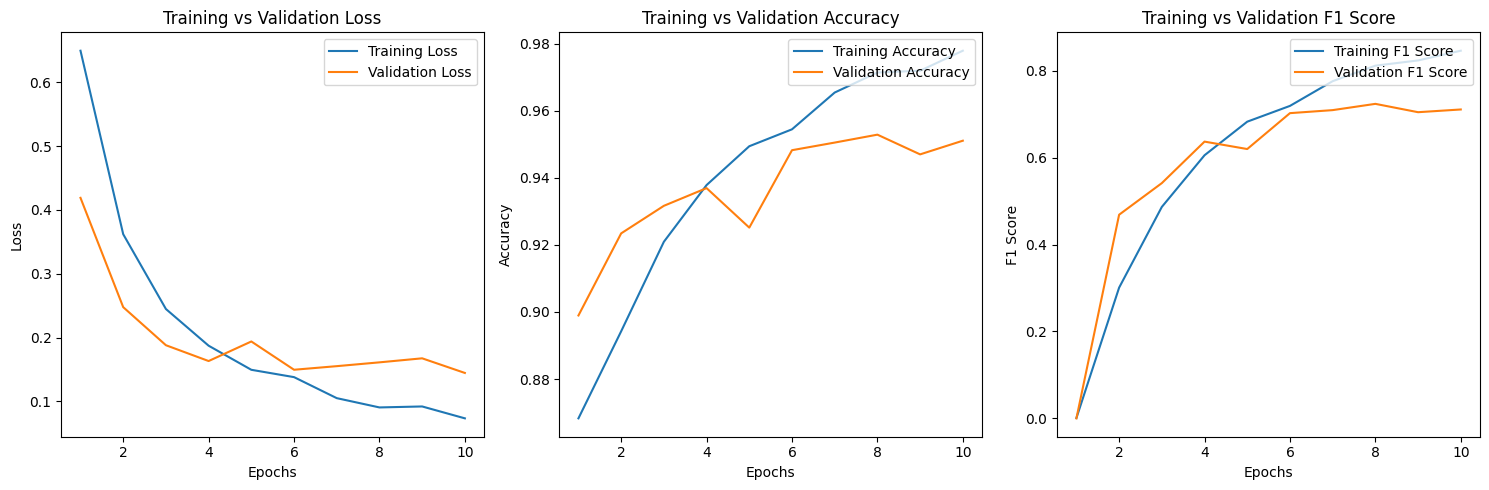

In [ ]:
epochs_range = range(1, epochs+1)

plt.figure(figsize=(15, 5))

#Plot for LOSS (Training vs Validation)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

#Plot for ACCURACY (Training vs Validation)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training vs Validation Accuracy')

#Plot for F1 SCORE (Training vs Validation)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_scores, label='Training F1 Score')
plt.plot(epochs_range, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend(loc='upper right')
plt.title('Training vs Validation F1 Score')

plt.tight_layout()
plt.show()

#### Test for assessing performance

In [ ]:
#TEST Phase

model.eval()

y_true = []
y_pred = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch

    with torch.no_grad():
        modelLogits = model(input_ids, token_type_ids=None, attention_mask=input_mask,)

    logits = modelLogits.logits.detach().cpu().numpy()
    logits = np.argmax(logits, axis=2)

    label_ids = label_ids.to('cpu').numpy()
    input_mask = input_mask.to('cpu').numpy()

    for i,mask in enumerate(input_mask):
        temp_1 = [] # Real one
        temp_2 = [] # Predict one

        for j, m in enumerate(mask):
            # Mark=0, meaning its a pad word, dont compare
            if m:
                if idx2tag[label_ids[i][j]] != "X" and idx2tag[label_ids[i][j]] != "[CLS]" and idx2tag[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1.append(idx2tag[label_ids[i][j]])
                    temp_2.append(idx2tag[logits[i][j]])
            else:
                break

        y_true.append(temp_1)
        y_pred.append(temp_2)

test_f1 = f1_score(y_true, y_pred)
test_accuracy = accuracy_score(y_true, y_pred)

print("F1 Score (Test): %f"%(test_f1))
print("Accuracy score (Test): %f"%(test_accuracy))

print(classification_report(y_true, y_pred, digits=4))

F1 Score (Test): 0.662112
Accuracy score (Test): 0.931681


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         CLG     0.4365    0.6014    0.5059       143
        CLS]     0.0000    0.0000    0.0000         0
     COMPANY     0.4153    0.6176    0.4966       238
         DEG     0.3908    0.5667    0.4626       120
       DESIG     0.3653    0.4841    0.4164       126
       EMAIL     0.8537    0.7997    0.8258       744
    GRADYEAR     0.4231    0.2245    0.2933        49
         LOC     0.6926    0.8165    0.7495       218
        NAME     0.9453    0.9758    0.9603       124
        SEP]     0.0000    0.0000    0.0000         0
      SKILLS     0.6964    0.6222    0.6572      1379
         YOE     0.2414    0.4667    0.3182        15

   micro avg     0.6492    0.6755    0.6621      3156
   macro avg     0.4550    0.5146    0.4738      3156
weighted avg     0.6788    0.6755    0.6720      3156



# Job matching

#### Prediction over chosen resume

In [ ]:
def prediction_function(resume):
  doc = list(nlp(resume))
  tokens = []

  for word in doc:
    token_list = tokenizer.tokenize(word.text)
    for m, token in enumerate(token_list):
      tokens.append(token)

  new_tokens = []

  if len(tokens) > 512:
    loop = True
    start = 0
    window_size = 512
    while loop:
      end = start + window_size
      if end >= len(tokens):
        loop = False
        end = len(tokens)
      input_resume_chunk = tokens[start : end]
      new_tokens.append(input_resume_chunk)
      start = end
  else:
    new_tokens.append(tokens)

  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in new_tokens],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  input_mask = [[float(i>0) for i in ii] for ii in input_ids]

  test_inputs = torch.tensor(input_ids)
  test_masks = torch.tensor(input_mask)

  model.eval()
  y_pred = []

  test_data = TensorDataset(test_inputs, test_masks)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

  for batch in test_dataloader:
      batch = tuple(t.to(device) for t in batch)
      input_ids, input_mask = batch

      with torch.no_grad():
          modelLogits = model(input_ids, token_type_ids=None, attention_mask=input_mask,)

      logits = modelLogits.logits.detach().cpu().numpy()
      logits = np.argmax(logits, axis=2)

      for i, mask in enumerate(input_mask):
          temp = [] # Predict one

          for j, m in enumerate(mask):
              # m = 0, meaning its a pad word, dont compare
              if m:
                  temp.append(idx2tag[logits[i][j]])
              else:
                  break

          y_pred.append(temp)

  return y_pred, new_tokens

In [ ]:
#function to return the table row of information
def get_predicted_info(person_idx):
  predictions, token_words = prediction_function(dataset['content'][person_idx])
  predictions = sum(predictions, [])
  token_words = sum(token_words, [])

  vocab = tokenizer.get_vocab()
  header = []
  unwanted = {'[SEP]', '[CLS]', 'X', 'O'}
  tag_list = [e[2:] for e in list(idx2tag.values()) if e not in unwanted]

  for elem in tag_list:
    header.append(elem)
  prediction_table = pd.DataFrame(columns = list(set(header)))

  table_row = {k: "" for k in tag_list}


  for i in range(len(predictions)):
    if predictions[i][2:] in tag_list:
      if (i>0 and predictions[i] == predictions[i-1]):
        table_row[predictions[i][2:]] = table_row[predictions[i][2:]] + token_words[i]
      else:
        table_row[predictions[i][2:]] = table_row[predictions[i][2:]] + " " + (token_words[i])

  prediction_table.loc[len(prediction_table)] = table_row

  return prediction_table

In [ ]:
person_idx = 3
prediction = get_predicted_info(person_idx)
prediction.loc[len(prediction)] = entity_table.iloc[person_idx]
prediction.index = ['pred', 'true']

prediction

,NAME,LOC,DESIG,CLG,EMAIL,SKILLS,GRADYEAR,COMPANY,DEG,YOE
pred,ok Khandai,Bengaluru Bengaluru Bengaluru Bengaluru,Operational Analyst(SQLDBA)Engineer Operation...,Indira Gand hi InstituteOfTechnologyĊ,indeed com/r/Alok-Khandai/5be849e443b8f467,Database SQL SqlDba Operating Environment Win...,2012,UNISYS UNISYS Microsoft Microsoft Microsoft M...,Ċ B.Tech inComputerScienceandEngineeringinCSEĊ,
true,Alok Khandai,Bengaluru Bengaluru Bengaluru Bengaluru,Operational Analyst ( SQL DBA ) Engineer Oper...,B.Tech in Computer Science and Engineering in...,indeed.com/r/Alok-Khandai/5be849e443b8f467,Database SQL Sql Dba Operating Environment Wi...,2012,UNISYS UNISYS,,


#### Job post dataset upload

In [ ]:
from google.colab import files
upload = files.upload()

Saving marketing_sample_for_indeed_co_in-indeed_co_in_job_data__20210401_20210630__30k_data_FILTERED_100samples.csv to marketing_sample_for_indeed_co_in-indeed_co_in_job_data__20210401_20210630__30k_data_FILTERED_100samples.csv


In [ ]:
file_path = '/content/marketing_sample_for_indeed_co_in-indeed_co_in_job_data__20210401_20210630__30k_data_FILTERED_100samples.csv'
df2 = pd.read_csv(file_path)
df2

,job_title,category,Location,company_name,job_description,job_type,company_description
0,Sales Executive,Marketing,"Ernakulam, Kerala, india",SpecZone Ventures,Conduct market research to identify selling po...,Full-time,Job Type: Full-time
1,Software Development Engineer,IT,"Noida, Uttar Pradesh, india",ayuda,MUST HAVES: 1. Graduate from Tier 1 college (I...,Full-time|Volunteer,2. More than 2 years of on-hand experience in ...
2,IT Service Engineer,Management,"Surat, Gujarat, india",Tresbien HR Company,Greetings from Tresbien HR Consultants ! Hirin...,Full-time,Hiring IT Service Engineer for a Engg MNC Co.
3,React Native Developer,IT,"Udipi, Karnataka, india",SASA Infotech Pvt. Ltd.,Job Opening for SASA Infotech Pvt Ltd. #Urgent...,Full-time,#UrgentlyRequired for React Native Developer F...
4,Immediate Opening For ReactJS Developers!!!,IT,"Chandigarh, Chandigarh, india",Zhagaram Software Solutions Pvt Ltd,Experience: 2+ Years Job Location: Chennai Job...,Full-time,Job Location: Chennai
...,...,...,...,...,...,...,...
95,Systems Analyst 3-Support,Management,"Mumbai, Maharashtra, india",Oracle,Systems Analyst 3-Support-21000GBT Applicants ...,Full-time,"Travel: Yes, 25 % of the Time"
96,Clinical Dietitian,Scientific,"Noida, Uttar Pradesh, india",Ketomaster,Job Description We are looking for a young ent...,Full-time,We are looking for a young enthusiastic & know...
97,Site Engineer,Engineering,"Gurgaon, Haryana, india",World Of Wonder Marketing Pvt. Ltd.,We are looking for a well-organized site engin...,Full-time|Commission|Fresher,Must Have Skills : -
98,Creative Content Writer,Marketing,"New Delhi, Delhi, india",Nursing Next Exam Prep Pvt. Ltd.,"ABOUT THE ROLE: If you’re creative, have a kna...",Part-time|Contract,"If you’re creative, have a knack to create imp..."


#### Similarity score

In [ ]:
def sim(Ideal_Answer, Submitted_Answer):
    # SBERT EMBEDDINGS
    text1=Ideal_Answer.replace("\"","").replace("\'","")
    text2=Submitted_Answer.replace("\"","").replace("\'","")

    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    #Compute embedding for both lists
    embedding_1= model.encode(text1, convert_to_tensor=True)
    embedding_2 = model.encode(text2, convert_to_tensor=True)

    score=util.pytorch_cos_sim(embedding_1, embedding_2)
    return float(score)

In [ ]:
def get_similarities(person_idx):
  # compute averaged similarities wrt:
  # LOC - Location
  # SKILLS - job_description
  # DESIG - job_title
  similarities_scores_dict = {}
  person_features = ['DESIG', 'SKILLS', 'LOC']
  job_features = ['job_title', 'job_description', 'Location']

  #row of predicted info data structure
  person_info_df = get_predicted_info(person_idx)

  #for each job in the dataset
  for i in range(len(df2)):
    job_sim_score = 0
    den = 0
    #for each feature of both person and job post
    for j in range(len(job_features)):
      try:
        job_sim_score += sim(person_info_df[person_features[j]], df2.iloc[i][job_features[j]])
      except Exception as e:
        print(e)
      else:
        den +=1
    similarities_scores_dict[i] = job_sim_score/den
    if i%10==0:
      print(i,'/100')

  similarities_scores_dict = dict(sorted(similarities_scores_dict.items(), key=lambda item: item[1], reverse=True))
  best_idx = list(similarities_scores_dict.items())[0][0]

  #returns: dict of (index of a job post, similarity score) + best job post index
  return similarities_scores_dict, best_idx

In [ ]:
scores_dict, best_idx = get_similarities(person_idx)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0 /100
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
10 /100
20 /100
30 /100
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
40 /100
'float' object has no attribute 'replace'
50 /100
60 /100
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
70 /100
80 /100
'float' object has no attribute 'replace'
'float' object has no attribute 'replace'
90 /100


In [ ]:
#Best company
df2.iloc[best_idx]

job_title                                            Cloud Data Engineer
category                                                      Management
Location                                     Bengaluru, Karnataka, india
company_name                                                   MoneyGram
job_description        The Cloud Data Engineer acts as liaison among ...
job_type                                                       Full-time
company_description                             Primary Responsibilities
Name: 32, dtype: object

#### Best matching companies histogram

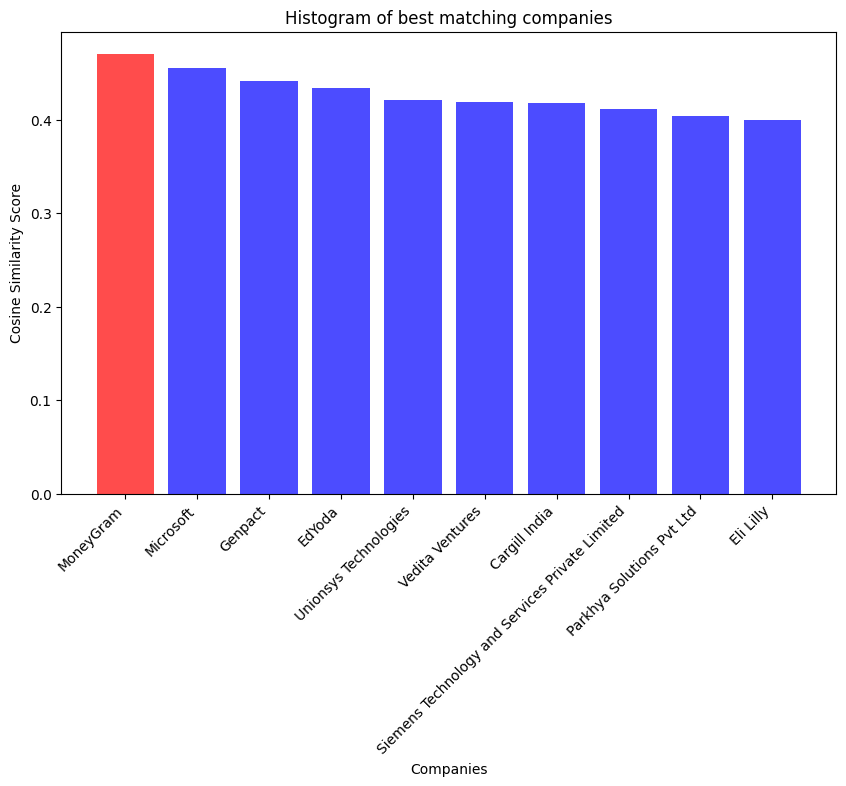

In [ ]:
n_companies = 10
similarity_dict_list = list(scores_dict.items())
company_scores = [similarity_dict_list[i][1] for i in range(n_companies)]
company_names = df2['company_name']
best_company_idx = [similarity_dict_list[i][0] for i in range(n_companies)]
best_company_names = [company_names[i] for i in best_company_idx]

# Create the histogram
plt.figure(figsize=(10, 6))

# Define colors for each bar
colors = ['red'] + ['blue'] * (n_companies - 1)
plt.bar(best_company_names, company_scores, color=colors, alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Add titles and labels
plt.title('Histogram of best matching companies')
plt.xlabel('Companies')
plt.ylabel('Cosine Similarity Score')

# Show the plot
plt.show()